In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list(),
    output = list(),
    params = list(),
    wildcards = list(),
    threads = 1,
    log = list( 'rds' = 'out/ipynb/compute_unsupervised_classification/pca.rds'),
    resources = list('tmpdir', "tmpdir" = '/tmp'),
    config = list(),
    rule = 'ipynb',
    bench_iteration = as.numeric(NA),
    scriptdir = '/mnt/thymus/synoSalva/illumina_sequencing_data/mw/mw-oncodiag/src/snakemake/rules/../../ipynb',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/mnt/thymus/synoSalva/illumina_sequencing_data/mw/mw-oncodiag');

######## snakemake preamble end #########


In [2]:
# start coding here

In [3]:
IRdisplay::display_markdown(
    sprintf(
"_Compute unsupervised classification %s_

__Oncodiag project__

[Guillaume Charbonnier](mailto:gc.bioinfo@gmail.com)

%s",
        snakemake@wildcards$design,
        format(Sys.Date(), "%Y-%m-%d")
    )
)

# Abstract

The aim of this analysis is to assess the main components of variance in the dataset.

# Methods

## Load depencies

### Packages

In [4]:
if (!require("BiocManager", quietly = TRUE)) {
    install.packages(
        "BiocManager",
        quiet = TRUE
    )
}
packages <- c(
  # "data.table",
  # "dplyr",
  "openxlsx",
  # "methylSig",
  "DSS",
  "bsseq",
  "ChIPpeakAnno",
  "irlba",
  # "ChIPseeker",
  # "methyAnalysis",
  "org.Hs.eg.db",
  "TxDb.Hsapiens.UCSC.hg19.knownGene",
  # "EnhancedVolcano",
  # "data.table",
  "ggpubr",
  # "ComplexHeatmap",
  "tidyr"
)
BiocManager::install(
    packages,
    update = FALSE,
    quiet = TRUE,
    Ncpus = parallel::detectCores()
)
invisible(
    lapply(
      packages,
      library,
      character.only = TRUE
    )
)

Bioconductor version '3.17' is out-of-date; the current release version '3.18'
  is available with R version '4.3'; see https://bioconductor.org/install

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.17 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'openxlsx' 'DSS' 'bsseq' 'ChIPpeakAnno' 'irlba'
  'org.Hs.eg.db' 'TxDb.Hsapiens.UCSC.hg19.knownGene' 'ggpubr' 'tidyr'”
Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames,

In [5]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /cobelix/spicuglia/mambaforge/envs/rkernel_diff_meth_v2/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] tidyr_1.3.0                            
 [2] ggpubr_0.6.0                           
 [3] ggplot2_3.4.4                          
 [4] TxDb.Hsapiens.UCSC.hg19.knownGene_3.2.2
 [5] GenomicFeatures_1.52.1                 
 [6] org.Hs.eg.db_3

In [132]:
set_plot_dim <- function(
    width = 16,
    height = 9
) {
    options(
        #jupyter.plot_scale=1,
        repr.plot.width = width,
        repr.plot.height = height
    )
}
set_plot_dim(5,5)

In [7]:
getwd()

[1] "/mnt/thymus/synoSalva/illumina_sequencing_data/mw/mw-oncodiag"

### Data

In [8]:
sample_metadata <- read.csv(
  "src/sample_sheets/all.csv"
)
# Here I temporarily subset the sample sheets to already available samples
suffix <- ".markdup.sorted_CpG.bedGraph"
input_dir <- "out/nextflow/nfcore_methylseq/methyldackel/"
files <- list.files(
    path = input_dir,
    pattern = suffix
)
samples <- sub(
    suffix,
    "",
    files
)
sample_metadata <- sample_metadata[sample_metadata$sample %in% samples,]
sample_metadata

,sample,fastq_1,fastq_2,patient_number,tissue
,<chr>,<chr>,<chr>,<int>,<chr>
1,ODG_080,inp/ONCODIAG/Novaseq_131222/fastq/ODG_080_S1_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_080_S1_R2_001.fastq.gz,1,normal
2,ODG_081,inp/ONCODIAG/Novaseq_131222/fastq/ODG_081_S2_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_081_S2_R2_001.fastq.gz,1,tumoral
3,ODG_082,inp/ONCODIAG/Novaseq_131222/fastq/ODG_082_S3_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_082_S3_R2_001.fastq.gz,2,normal
4,ODG_083,inp/ONCODIAG/Novaseq_131222/fastq/ODG_083_S4_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_083_S4_R2_001.fastq.gz,2,tumoral
5,ODG_084,inp/ONCODIAG/Novaseq_131222/fastq/ODG_084_S5_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_084_S5_R2_001.fastq.gz,3,normal
6,ODG_085,inp/ONCODIAG/Novaseq_131222/fastq/ODG_085_S6_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_085_S6_R2_001.fastq.gz,3,tumoral
7,ODG_086,inp/ONCODIAG/Novaseq_131222/fastq/ODG_086_S7_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_086_S7_R2_001.fastq.gz,4,normal
8,ODG_087,inp/ONCODIAG/Novaseq_131222/fastq/ODG_087_S8_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_087_S8_R2_001.fastq.gz,4,tumoral
9,ODG_088,inp/ONCODIAG/Novaseq_131222/fastq/ODG_088_S9_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_088_S9_R2_001.fastq.gz,5,normal


In [9]:
# This will be used to load files with read.bismarck()
sample_metadata$bedGraph <- paste0(
    'out/nextflow/nfcore_methylseq/methyldackel/',
    sample_metadata$sample,
    '.markdup.sorted_CpG.bedGraph'
)

In [10]:
# row.names should be declared to be used as row.names of the BSseq object
# because DMLtest() uses these row.namesto select samples
row.names(sample_metadata) <- sample_metadata$sample
sample_metadata

,sample,fastq_1,fastq_2,patient_number,tissue,bedGraph
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
ODG_080,ODG_080,inp/ONCODIAG/Novaseq_131222/fastq/ODG_080_S1_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_080_S1_R2_001.fastq.gz,1,normal,out/nextflow/nfcore_methylseq/methyldackel/ODG_080.markdup.sorted_CpG.bedGraph
ODG_081,ODG_081,inp/ONCODIAG/Novaseq_131222/fastq/ODG_081_S2_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_081_S2_R2_001.fastq.gz,1,tumoral,out/nextflow/nfcore_methylseq/methyldackel/ODG_081.markdup.sorted_CpG.bedGraph
ODG_082,ODG_082,inp/ONCODIAG/Novaseq_131222/fastq/ODG_082_S3_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_082_S3_R2_001.fastq.gz,2,normal,out/nextflow/nfcore_methylseq/methyldackel/ODG_082.markdup.sorted_CpG.bedGraph
ODG_083,ODG_083,inp/ONCODIAG/Novaseq_131222/fastq/ODG_083_S4_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_083_S4_R2_001.fastq.gz,2,tumoral,out/nextflow/nfcore_methylseq/methyldackel/ODG_083.markdup.sorted_CpG.bedGraph
ODG_084,ODG_084,inp/ONCODIAG/Novaseq_131222/fastq/ODG_084_S5_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_084_S5_R2_001.fastq.gz,3,normal,out/nextflow/nfcore_methylseq/methyldackel/ODG_084.markdup.sorted_CpG.bedGraph
ODG_085,ODG_085,inp/ONCODIAG/Novaseq_131222/fastq/ODG_085_S6_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_085_S6_R2_001.fastq.gz,3,tumoral,out/nextflow/nfcore_methylseq/methyldackel/ODG_085.markdup.sorted_CpG.bedGraph
ODG_086,ODG_086,inp/ONCODIAG/Novaseq_131222/fastq/ODG_086_S7_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_086_S7_R2_001.fastq.gz,4,normal,out/nextflow/nfcore_methylseq/methyldackel/ODG_086.markdup.sorted_CpG.bedGraph
ODG_087,ODG_087,inp/ONCODIAG/Novaseq_131222/fastq/ODG_087_S8_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_087_S8_R2_001.fastq.gz,4,tumoral,out/nextflow/nfcore_methylseq/methyldackel/ODG_087.markdup.sorted_CpG.bedGraph
ODG_088,ODG_088,inp/ONCODIAG/Novaseq_131222/fastq/ODG_088_S9_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_088_S9_R2_001.fastq.gz,5,normal,out/nextflow/nfcore_methylseq/methyldackel/ODG_088.markdup.sorted_CpG.bedGraph


In [11]:
bsseq_stranded = bsseq::read.bismark(
    files = sample_metadata$bedGraph,
    colData = sample_metadata,
    rmZeroCov = TRUE,
    strandCollapse = TRUE,
    BACKEND = "HDF5Array",
    dir = sub(
        ".rds",
        "hdf5a",
        snakemake@log$rds
    ),
    replace = TRUE
)
bsseq_stranded

Loading required package: DelayedArray

Loading required package: S4Arrays


Attaching package: ‘S4Arrays’


The following object is masked from ‘package:base’:

    rowsum



Attaching package: ‘DelayedArray’


The following objects are masked from ‘package:base’:

    apply, scale, sweep


Loading required package: rhdf5


Attaching package: ‘HDF5Array’


The following object is masked from ‘package:rhdf5’:

    h5ls




An object of type 'BSseq' with
  55628636 methylation loci
  30 samples
has not been smoothed
Some assays are HDF5Array-backed

In [12]:
mean_cov <- rowMeans(getCoverage(bsseq_stranded))
quantile(mean_cov)

0%          25%          50%          75%         100% 
3.333333e-02 7.566667e+00 8.633333e+00 9.733333e+00 1.840867e+04

In [15]:
min_cov <- rowMins(getCoverage(bsseq_stranded))
quantile(min_cov)

0%  25%  50%  75% 100% 
   0    0    0    0 3696

In [13]:
cg_sd <- rowSds(
    getMeth(
        bsseq_stranded,
        type="raw"
    ),
)
# Replace NA by 0 to remove them later with low sd sites
cg_sd[is.na(cg_sd)] <- 0
quantile(cg_sd)

0%       25%       50%       75%      100% 
0.0000000 0.0000000 0.0000000 0.0000000 0.5074163

In [14]:
length(mean_cov)
length(cg_sd)

[1] 55628636

[1] 55628636

In [143]:
n_low_coverage_sites_by_sample <-apply(
    as.matrix(getCoverage(bsseq_stranded)),
    2,
    FUN = function(x) {sum(x < 5)}
)
n_low_coverage_sites_by_sample[1:3]

ODG_080  ODG_081  ODG_082 
14506712  5185380  3604892

In [147]:
colData(bsseq_stranded)

DataFrame with 30 rows and 6 columns
             sample                fastq_1                fastq_2
        <character>            <character>            <character>
ODG_080     ODG_080 inp/ONCODIAG/Novaseq.. inp/ONCODIAG/Novaseq..
ODG_081     ODG_081 inp/ONCODIAG/Novaseq.. inp/ONCODIAG/Novaseq..
ODG_082     ODG_082 inp/ONCODIAG/Novaseq.. inp/ONCODIAG/Novaseq..
ODG_083     ODG_083 inp/ONCODIAG/Novaseq.. inp/ONCODIAG/Novaseq..
ODG_084     ODG_084 inp/ONCODIAG/Novaseq.. inp/ONCODIAG/Novaseq..
...             ...                    ...                    ...
ODG_105     ODG_105 inp/ONCODIAG/Novaseq.. inp/ONCODIAG/Novaseq..
ODG_106     ODG_106 inp/ONCODIAG/Novaseq.. inp/ONCODIAG/Novaseq..
ODG_107     ODG_107 inp/ONCODIAG/Novaseq.. inp/ONCODIAG/Novaseq..
ODG_108     ODG_108 inp/ONCODIAG/Novaseq.. inp/ONCODIAG/Novaseq..
ODG_109     ODG_109 inp/ONCODIAG/Novaseq.. inp/ONCODIAG/Novaseq..
        patient_number      tissue               bedGraph
             <integer> <character>            <

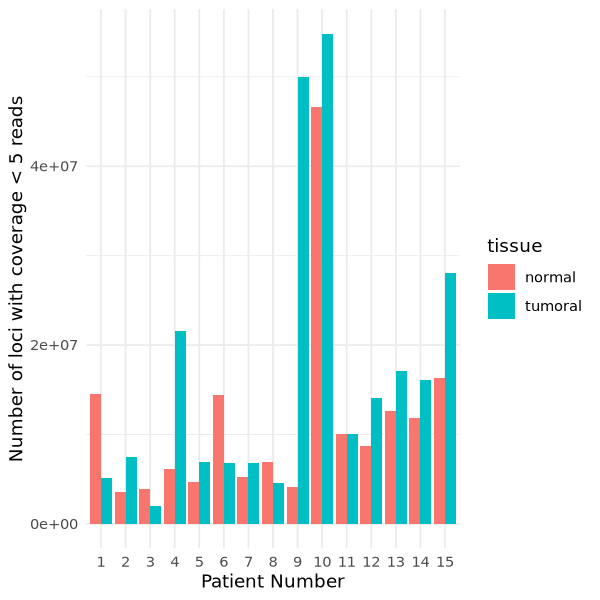

In [151]:
df <- data.frame(
    colData(bsseq_stranded)[, c("patient_number", "tissue")],
    n_low_coverage_sites_by_sample
)
df$patient_number <- factor(df$patient_number)
ggplot(df, aes(x = patient_number, y = n_low_coverage_sites_by_sample, fill = tissue)) +
  geom_bar(stat = "identity", position = "dodge") +
  xlab("Patient Number") +
  ylab("Number of loci with coverage < 5 reads") +
#   ggtitle("Proportions of Methylation Values\nBelow 0.2 and Above 0.8") +
  theme_minimal()


Because of the high number of low coverage loci in patient 9 and 10, it is better to produce downstream plots without them.

In [152]:
# Subset for the sole purpose to have 
bsseq_subset <- bsseq_stranded[
    {
        mean_cov > 10 &
        # min_cov > 3 &
        cg_sd > 0.2
    },
    # We remove the patient 10 because it has very low coverage samples that bias the plots below
    !colData(bsseq_stranded)$patient_number %in% c(9,10)
]
bsseq_subset

An object of type 'BSseq' with
  1340059 methylation loci
  26 samples
has not been smoothed
Some assays are HDF5Array-backed

In [153]:
beta_values <- as.matrix(
        getMeth(
            bsseq_subset,
            type="raw"
        )
    )

# # Get coverage
# coverage <- as.matrix(getCoverage(bsseq_subset))

# # Define a threshold for low coverage
# threshold <- 10

# # Replace low coverage values with NA
# beta_values[coverage < threshold] <- NA

# beta_values[1:5,1:4]


In [154]:
pca_result <- prcomp_irlba(
    x = t(beta_values),
    n = 5,
    scale = FALSE
)

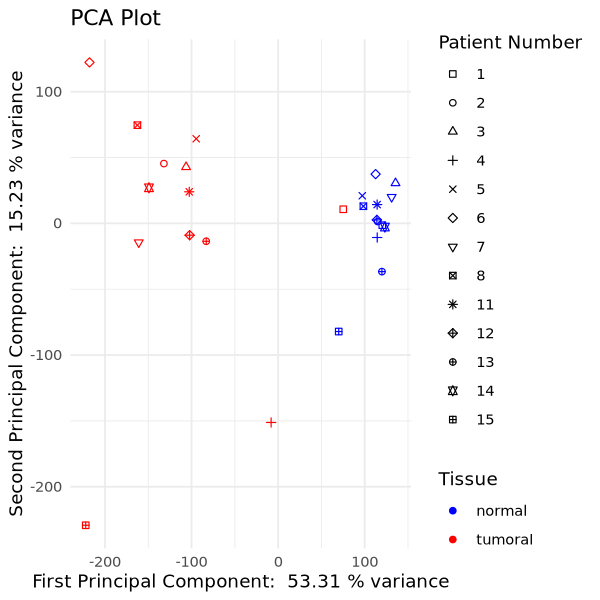

In [155]:
# Calculate the percentage of variance explained by each principal component
variance_explained <- pca_result$sdev^2 / sum(pca_result$sdev^2)

# Extract the first two principal components
pca_df <- data.frame(pca_result$x[,1:2])

# Name the columns
colnames(pca_df) <- c("PC1", "PC2")

# Create a combined data frame
combined_df <- cbind(pca_df, colData(bsseq_subset))
combined_df$patient_number <- factor(combined_df$patient_number)
# Create the plot
# Define a vector of shapes
shapes <- c(0:14, 21:25)

# Create the plot
ggplot(combined_df, aes(x=PC1, y=PC2, color=tissue, shape = patient_number)) +
  geom_point() +
  scale_shape_manual(values = shapes) +
  scale_color_manual(values = c("tumoral" = "red", "normal" = "blue")) +
  xlab(paste("First Principal Component: ", round(variance_explained[1] * 100, 2), "% variance")) +
  ylab(paste("Second Principal Component: ", round(variance_explained[2] * 100, 2), "% variance")) +
  ggtitle("PCA Plot") +
  theme_minimal() +
  labs(color = "Tissue", shape = "Patient Number")

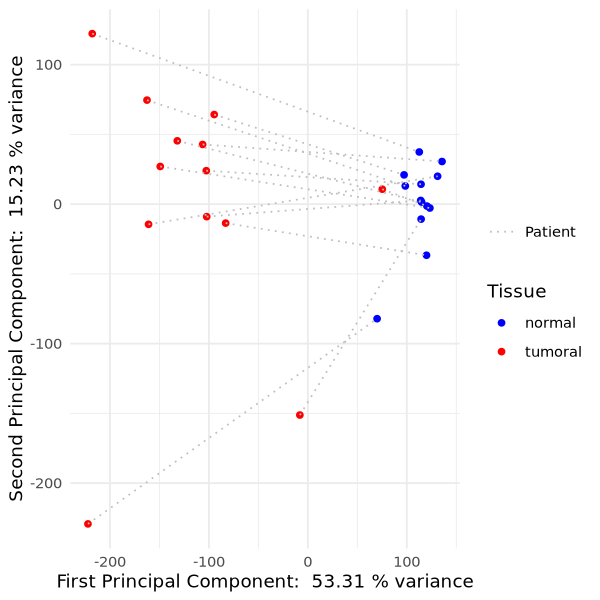

In [179]:
# Create the plot
p <- ggplot(combined_df, aes(x=PC1, y=PC2, color=tissue, group = patient_number)) +
  geom_point() +
  geom_line(aes(linetype = "patient"), color = "grey") + # Add linetype aesthetic
  scale_color_manual(values = c("tumoral" = "red", "normal" = "blue")) +
  scale_linetype_manual(values = c("patient" = "dotted"), name = "", labels = "Patient") + # Add custom legend
  xlab(paste("First Principal Component: ", round(variance_explained[1] * 100, 2), "% variance")) +
  ylab(paste("Second Principal Component: ", round(variance_explained[2] * 100, 2), "% variance")) +
  # ggtitle("PCA Plot") +
  theme_minimal() +
  labs(color = "Tissue")
p
ggsave(
  p,
  file = "PCA_for_article.pdf",
  width = 5,
  height = 5
)

In [157]:
# Get the number of columns in the matrix
num_cols <- ncol(beta_values)

# Initialize vectors to store the proportions
prop_below_0_2 <- numeric(num_cols)
prop_above_0_8 <- numeric(num_cols)

# Calculate the proportions for each column
for (i in 1:num_cols) {
  prop_below_0_2[i] <- sum(beta_values[, i] < 0.2) / length(beta_values[, i])
  prop_above_0_8[i] <- sum(beta_values[, i] > 0.8) / length(beta_values[, i])
}

# Create a data frame for plotting
plot_df <- data.frame(Column = 1:num_cols, 
                      Below_0_2 = prop_below_0_2, 
                      Above_0_8 = prop_above_0_8)

# Reshape the data frame for plotting
library(reshape2)
plot_df_melt <- melt(plot_df, id.vars = "Column")


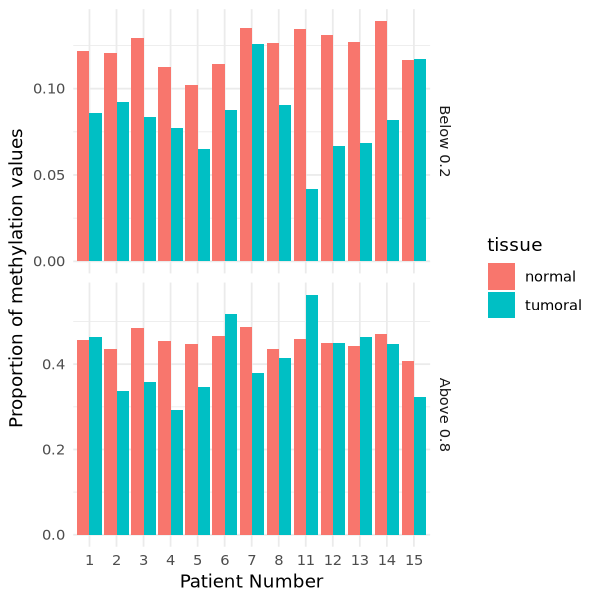

In [174]:
# Add patient_number to the data frame
plot_df$patient_number <- colData(bsseq_subset)$patient_number
plot_df$tissue <- colData(bsseq_subset)$tissue
plot_df$patient_number <- factor(plot_df$patient_number)
# Reshape the data frame for plotting
library(reshape2)
plot_df_melt <- melt(plot_df, id.vars = c("Column", "patient_number","tissue"))
# plot_df_melt
# Create the plot
library(ggplot2)
ggplot(plot_df_melt, aes(x = patient_number, y = value, fill = tissue)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_grid(variable~., scales = "free", labeller = as_labeller(c(Below_0_2 = "Below 0.2", Above_0_8 = "Above 0.8"))) +
  xlab("Patient Number") +
  ylab("Proportion of methylation values") +
  # ggtitle("Proportions of Methylation Values\nBelow 0.2 and Above 0.8") +
  theme_minimal()


We remove the patient number for the article figure because they are irrelevant and would highlight the two low-quality patients that we removed from the analysis.

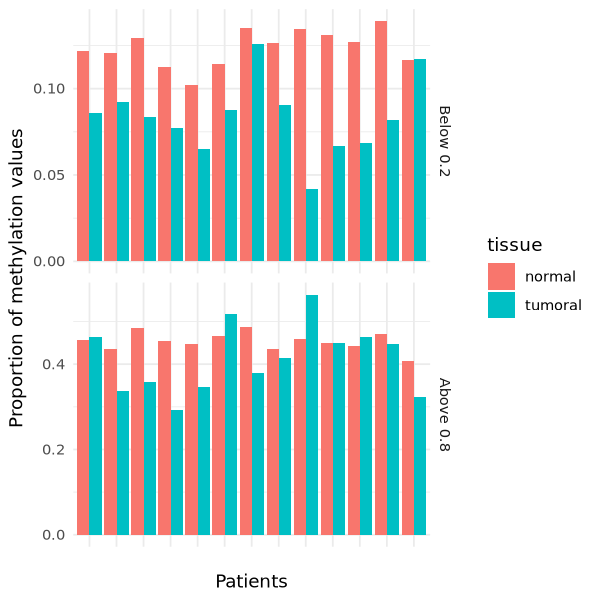

In [181]:
p <- ggplot(plot_df_melt, aes(x = patient_number, y = value, fill = tissue)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_grid(variable~., scales = "free", labeller = as_labeller(c(Below_0_2 = "Below 0.2", Above_0_8 = "Above 0.8"))) +
  scale_x_discrete(labels = function(x) vector("character", length(x))) + # Hide x-axis labels
  xlab("Patients") + # Change xlab to "Patients"
  ylab("Proportion of methylation values") +
  theme_minimal()
p
ggsave(
  p,
  file = "Barplots_for_article.pdf",
  width = 5,
  height = 5
)

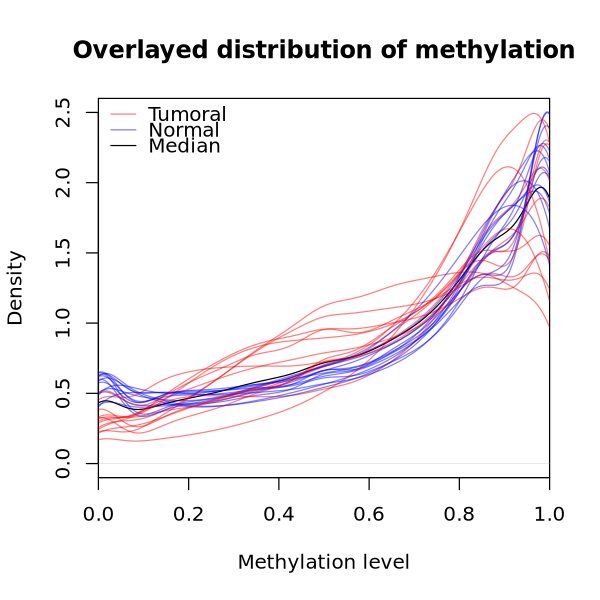

In [163]:
# Get the number of columns in the matrix
num_cols <- ncol(beta_values)

my_bw <- 0.05
# Calculate the density of the entire matrix
dens_all <- density(as.vector(beta_values), from = 0, to = 1, bw = my_bw)

# Plot the density of the entire matrix as a black line
plot(
    dens_all,
    xlim = c(0,1),
    ylim = c(0, 2.5),
    xlab = "Methylation level",
    ylab = "Density",
    main = "Overlayed distribution of methylation",
    xaxs = "i",
    col = "black"
)

# Loop over each column in the matrix
for (i in 1:num_cols) {
  # Get the density of the current column
  dens <- density(beta_values[, i], from = 0, to = 1, bw = my_bw)
  
  # Get the color for the current column based on 'Status'
  col <- ifelse(
    colData(bsseq_subset)$tissue[i] == "tumoral",
    "#ff000080",
    "#0000ff80"
  )
  
  # Add the density curve to the plot
  lines(dens, col = col)
}

# Add a legend
legend(
  "topleft", 
  legend = c("Tumoral", "Normal", "Median"),
  col = c("#ff000080", "#0000ff80", "black"),
  lty = 1,
  bty = "n"
)

In [184]:
pdf("lineplots_for_article.pdf", width = 5, height = 5)
# Get the number of columns in the matrix
num_cols <- ncol(beta_values)

my_bw <- 0.05

# Loop over each column in the matrix
for (i in 1:num_cols) {
  # Get the density of the current column
  dens <- density(beta_values[, i], from = 0, to = 1, bw = my_bw)
  
  # Get the color for the current column based on 'Status'
  col <- ifelse(
    colData(bsseq_subset)$tissue[i] == "tumoral",
    "#ff000080",
    "#0000ff80"
  )
  
  # Add the density curve to the plot
  if(i == 1){
    plot(
      dens,
      xlim = c(0,1),
      ylim = c(0, 2.5),
      xlab = "Methylation level",
      ylab = "Density of occurences in loci",
      # main = "Overlayed distribution of methylation",
      main = NA,
      xaxs = "i",
      yaxs = "i",
      col = col
    )
  } else {
    lines(dens, col = col)
  }
}

# Add a legend
legend(
  "topleft", 
  legend = c("Tumoral", "Normal"),
  col = c("#ff000080", "#0000ff80"),
  lty = 1,
  bty = "n"
)
dev.off()

png 
  2

We observe some artefactual peaks at intermediate values resulting from low coverage loci: 1/2, 2/3, 1,3, etc... We need to only consider loci-sample pairs with good coverage:

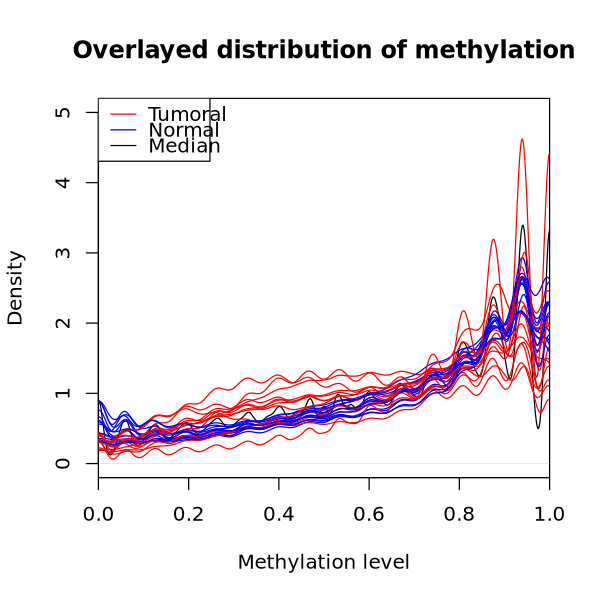

In [161]:
beta_value_high_cov <- beta_values
# Get coverage
coverage <- as.matrix(getCoverage(bsseq_subset))

# Define a threshold for low coverage
threshold <- 15

# Replace low coverage values with NA
beta_value_high_cov[coverage < threshold] <- NA

# Get the number of columns in the matrix
num_cols <- ncol(beta_value_high_cov)

# Calculate the density of the entire matrix
dens_all <- density(na.omit(as.vector(beta_value_high_cov)), from = 0, to = 1)

# Plot the density of the entire matrix as a black line
plot(
    dens_all,
    xlim = c(0,1),
    ylim = c(0, 5),
    xlab = "Methylation level",
    ylab = "Density",
    main = "Overlayed distribution of methylation",
    xaxs = "i",
    col = "black"
)

# Loop over each column in the matrix
for (i in 1:num_cols) {
  # Get the density of the current column
  dens <- density(na.omit(beta_value_high_cov[, i]), from = 0, to = 1)
  
  # Get the color for the current column based on 'Status'
  col <- ifelse(colData(bsseq_subset)$tissue[i] == "tumoral", "red", "blue")
  
  # Add the density curve to the plot
  lines(dens, col = col)
}

# Add a legend
legend(
  "topleft", 
  legend = c("Tumoral", "Normal", "Median"),
  col = c("red", "blue", "black"),
  lty = 1
)

In [162]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /cobelix/spicuglia/mambaforge/envs/rkernel_diff_meth_v2/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] reshape2_1.4.4                         
 [2] HDF5Array_1.28.1                       
 [3] rhdf5_2.44.0                           
 [4] DelayedArray_0.26.6                    
 [5] S4Arrays_1.0.4                         
 [6] tidyr_1.3.0   